In [1]:
#-----------------------------------------------------------------------------
# Importa bibliotecas e define variáveis
#-----------------------------------------------------------------------------

import numpy as np
import pandas as pd
import scipy as sp
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as opt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import minmax_scale
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import Bounds
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Lasso, LassoCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import Ridge, RidgeCV, RidgeClassifierCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, recall_score, precision_score, accuracy_score

In [2]:
# Parâmetros
janela_reb = 126
janela_retornos = 252
janela_indic = 252
custo = 0.01
rnd_state = 0
thresh = 0.65
target_retorno = 0.2
str_dir = 'C:/Users/nelly/Desktop/Mestrado Insper/DISSERTAÇÃO/Dissertação/1. Modelo/'

# Estilo dos gráficos
sns.set(color_codes = True)
plt.rcParams['figure.dpi'] = 300 # Resolução dos gráficos impressos no pdf (dpi)
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')


In [3]:
#-----------------------------------------------------------------------------
# Define funções - Otimização de Portfolio Markowitz
#-----------------------------------------------------------------------------

def get_port(mu,cov,df_y_hat_local_T,w_barra,wu,gamma):
    
    N_t = df_y_hat_local_T.shape[1]
    n_pc = df_y_hat_local_T.shape[0]
    
    theta0 = np.zeros(n_pc)
    
    x_t = np.array(df_y_hat_local_T)
    
    alfa1 = 10e9
    alfa2 = 10e9
    alfa3 = 10e9
    
    fun = lambda theta: -((1 + (w_barra + (1/N_t)*(theta).dot(x_t)).dot(np.array(mu)) - \
                            np.abs((w_barra + (1/N_t)*(theta).dot(x_t))-wu).sum()*custo)**(1-gamma)-1)/(1-gamma) + \
                            alfa1*((w_barra + (1/N_t)*theta.dot(x_t)).sum() - 1)**2 + \
                            alfa2*np.max((w_barra + (1/N_t)*theta.dot(x_t))<-0.2)**2 + \
                            alfa3*np.max((w_barra + (1/N_t)*theta.dot(x_t))>0.2)**2

    res = opt.minimize(fun, theta0, method='Nelder-Mead',
                       options={'maxiter':10000, 'ftol': 1e-07, 'disp':True})
    
    theta = pd.Series(data=res.x)
    
    w = w_barra + (1/N_t)*(theta).dot(x_t)
    
    r_opt = (w_barra + (1/N_t)*(theta).dot(x_t)).dot(np.array(mu)) - np.abs(((w_barra + (1/N_t)*(theta).dot(x_t))-wu)).sum()*custo
    
    vol_opt = (w_barra + (1/N_t)*(theta).dot(x_t)).dot(cov).dot((w_barra + (1/N_t)*(theta).dot(x_t)))
    
    return w, res.fun, r_opt, vol_opt, theta

In [4]:
str_indic_full = ['EBITDA_MARGIN','EBIT_MARGIN',
                  'RETURN_COM_EQY','RETURN_ON_ASSET','RETURN_ON_CAP','RETURN_ON_INV_CAPITAL',
                  'OPER_MARGIN','ASSET_TURNOVER','CUR_RATIO','QUICK_RATIO',
                  'INT_COVERAGE_RATIO','DEGREE_FINANCIAL_LEVERAGE',
                  'BS_LEV_RATIO_TO_TANG_CAP','BEST_DIV_YLD','DVD_PAYOUT_RATIO',
                  'EV_TO_T12M_EBITDA','EV_TO_T12M_EBIT','PX_TO_BOOK_RATIO','PE_RATIO',
                  'PX_TO_SALES_RATIO','CURRENT_EV_TO_12M_SALES','BEST_PEG_RATIO',
                  'NET_INCOME_TO_COMMON_MARGIN','CUR_MKT_CAP',
                  'PX_TO_CASH_FLOW','PX_TO_FREE_CASH_FLOW','EQY_DVD_YLD_12M_NET',
                  'CASH_CONVERSION_CYCLE','OPERATING_ROIC','PRETAX_ROCE']
str_tickers_full = ['VALE3 BS Equity','B3SA3 BS Equity','ITUB4 BS Equity','PETR4 BS Equity',
               'BBDC4 BS Equity','PETR3 BS Equity','ABEV3 BS Equity','WEGE3 BS Equity',
               'BBAS3 BS Equity','ITSA4 BS Equity','JBSS3 BS Equity','NTCO3 BS Equity',
               'LREN3 BS Equity','RENT3 BS Equity','LAME4 BS Equity','BBDC3 BS Equity',
               'EQTL3 BS Equity','RADL3 BS Equity','VIVT4 BS Equity','UGPA3 BS Equity',
               'SBSP3 BS Equity','GGBR4 BS Equity','BRFS3 BS Equity','CCRO3 BS Equity',
               'HYPE3 BS Equity','SULA11 BS Equity','COGN3 BS Equity','CSAN3 BS Equity',
               'ENGI11 BS Equity','TOTS3 BS Equity','EGIE3 BS Equity','CMIG4 BS Equity',
               'YDUQ3 BS Equity','CSNA3 BS Equity','BRML3 BS Equity','CYRE3 BS Equity',
               'TAEE11 BS Equity','BRKM5 BS Equity','MULT3 BS Equity','EMBR3 BS Equity',
               'GOAU4 BS Equity','MRVE3 BS Equity','ENBR3 BS Equity','CPFE3 BS Equity',
               'USIM5 BS Equity','HGTX3 BS Equity']

df_full = pd.read_csv(filepath_or_buffer = str_dir + 'Indicadores Nelly' + '.csv', sep=';')
df_full.index = df_full['Date']
df_full = df_full.drop(columns=['Date'])
df_full['indice'] = np.zeros(len(df_full.index))

for x in range(0,len(df_full.index)):
    df_full.iloc[x,len(df_full.columns)-1] = datetime.datetime(df_full.iloc[x,2],df_full.iloc[x,1], df_full.iloc[x,0])

df_full = df_full.drop(columns=['Day', 'Month', 'Year'])
df_full.index = df_full['indice']
df_full = df_full.drop(columns=['indice'])

df_full = df_full.iloc[(252*10):,]

In [5]:
# Importa base de retornos das ações do Ibovespa 
str_Retornos = 'Retornos Nelly'
    
df_Retornos = pd.read_csv(filepath_or_buffer = str_dir + str_Retornos + '.csv', sep=';')
df_Retornos.index = df_Retornos['Data']
df_Retornos = df_Retornos.drop(columns=['Data'])
df_Retornos = df_Retornos.dropna()
    
df_Retornos['indice']=np.zeros(len(df_Retornos.index))
    
for x in range(0,len(df_Retornos.index)):
    df_Retornos.iloc[x,len(df_Retornos.columns)-1] = datetime.datetime(df_Retornos.iloc[x,2],df_Retornos.iloc[x,1], df_Retornos.iloc[x,0])
    
df_Retornos = df_Retornos.drop(columns=['Day', 'Month', 'Year'])
df_Retornos.index = df_Retornos['indice']
df_Retornos = df_Retornos.drop(columns=['indice'])

# Importa base de pesos das ações do portfolio     
str_w0 = 'Market_Cap'
    
df_w0 = pd.read_csv(filepath_or_buffer = str_dir + str_w0 + '.csv', sep=';')
df_w0.index = df_w0['Data']
df_w0 = df_w0.drop(columns=['Data'])
df_w0 = df_w0.dropna()
    
df_w0['indice']=np.zeros(len(df_w0.index))
    
for x in range(0,len(df_w0.index)):
    df_w0.iloc[x,len(df_w0.columns)-1] = datetime.datetime(df_w0.iloc[x,2],df_w0.iloc[x,1], df_w0.iloc[x,0])
    
df_w0 = df_w0.drop(columns=['Day', 'Month', 'Year'])
df_w0.index = df_w0['indice']
df_w0 = df_w0.drop(columns=['indice'])


In [6]:
# Ajusta série de datas
data_retornos = pd.DataFrame(df_Retornos.index)
data_indic = pd.DataFrame(df_full.index)
data_series = data_retornos.merge(data_indic, left_on = 'indice', right_on = 'indice')

df_Retornos = df_Retornos[df_Retornos.index.isin(data_series['indice'])]
df_full = df_full[df_full.index.isin(data_series['indice'])]
df_w0 = df_w0[df_w0.index.isin(data_series['indice'])]

num_indic = len(str_indic_full)
v_pos_indics = []
j = 0
while j != len(df_full.columns):
    if np.isnan(df_full.iloc[0,j]) or df_full.iloc[0,j] == 0 or df_full.iloc[0,j] == 'NaN':
        pos_indic = j%num_indic
        indic_list = False
        for i in range(0,len(v_pos_indics)):
            if v_pos_indics[i] == pos_indic:
                indic_list = True
        if indic_list == False:
            v_pos_indics.append(pos_indic)
    j = j + 1
str_indic_full_aux = []
for i in range(0,len(str_indic_full)):
    if i not in v_pos_indics:
        str_indic_full_aux.append(str_indic_full[i])
str_indic_full = str_indic_full_aux
str_drop_cols = []
for i in range(0, len(v_pos_indics)):
    col = v_pos_indics[i]
    while col < len(df_full.columns):
        str_drop_cols.append(df_full.columns[col])
        col = col + num_indic
df_full = df_full.drop(labels = str_drop_cols, axis = 1)

df_GROSS_MARGIN = pd.DataFrame()
df_EBITDA_MARGIN = pd.DataFrame()
df_PROF_MARGIN = pd.DataFrame()
df_EBIT_MARGIN = pd.DataFrame()
df_RETURN_COM_EQY = pd.DataFrame()
df_RETURN_ON_ASSET = pd.DataFrame()
df_RETURN_ON_CAP = pd.DataFrame()
df_RETURN_ON_INV_CAPITAL = pd.DataFrame()
df_OPER_MARGIN = pd.DataFrame()
df_ASSET_TURNOVER = pd.DataFrame()
df_CUR_RATIO = pd.DataFrame()
df_QUICK_RATIO = pd.DataFrame()
df_INT_COVERAGE_RATIO = pd.DataFrame()
df_DEGREE_FINANCIAL_LEVERAGE = pd.DataFrame()
df_BS_LEV_RATIO_TO_TANG_CAP = pd.DataFrame()
df_BEST_DIV_YLD = pd.DataFrame()
df_DVD_PAYOUT_RATIO = pd.DataFrame()
df_EV_TO_T12M_EBITDA = pd.DataFrame()
df_EV_TO_T12M_EBIT = pd.DataFrame()
df_PX_TO_BOOK_RATIO = pd.DataFrame()
df_PE_RATIO = pd.DataFrame()
df_PX_TO_SALES_RATIO = pd.DataFrame()
df_CURRENT_EV_TO_12M_SALES = pd.DataFrame()
df_BEST_PEG_RATIO = pd.DataFrame()
df_PROF_MARGIN = pd.DataFrame()
df_NET_INCOME_TO_COMMON_MARGIN = pd.DataFrame()
df_CUR_MKT_CAP = pd.DataFrame()
df_PX_TO_CASH_FLOW = pd.DataFrame()
df_PX_TO_FREE_CASH_FLOW = pd.DataFrame()
df_EQY_DVD_YLD_12M_NET = pd.DataFrame()
df_CASH_CONVERSION_CYCLE = pd.DataFrame()
df_OPERATING_ROIC = pd.DataFrame()
df_PRETAX_ROCE = pd.DataFrame()

col = 0
j = 0
num_indic = len(str_indic_full)
for indic in str_indic_full:
    while col < df_full.shape[1]:
        globals()['df_' + indic] = pd.concat([globals()['df_' + indic], 
                                              df_full.iloc[:,col]], axis = 1)
        col = col + num_indic
    globals()['df_' + indic].columns = str_tickers_full
    j = j + 1
    col = j

In [7]:
# Definição dos tickers a serem consultados nas bases para otimização
str_tickers = str_tickers_full

# Definição dos indicadores que serão utilizados para ajustar os modelos
str_indic = str_indic_full

# Definição de parâmetros para rodar a otimização 
str_models = ['RF', 'KNN', 'LASSO', 'RIDGE', 'SVC', 'BAYES']
t = janela_indic
T = len(df_RETURN_COM_EQY)

wu = np.zeros(len(str_tickers))
df_w = pd.DataFrame()
df_r = pd.DataFrame()
df_Vol = pd.DataFrame()
df_Utility = pd.DataFrame()
df_theta = pd.DataFrame()

df_indic_stocks_ini_hist = pd.DataFrame()

df_y_fit_local_RF_T_hist = pd.DataFrame()
df_y_fit_local_Log_T_hist = pd.DataFrame()
df_y_fit_local_ridge_T_hist = pd.DataFrame()
df_y_fit_local_bagging_T_hist = pd.DataFrame()
df_y_fit_local_knn_T_hist = pd.DataFrame()
df_y_fit_local_lasso_T_hist = pd.DataFrame()
df_y_fit_local_bayes_T_hist = pd.DataFrame()

df_y_hat_local_MLP1_T_hist = pd.DataFrame()
df_y_hat_local_RF_T_hist = pd.DataFrame()
df_y_hat_local_Log_T_hist = pd.DataFrame()
df_y_hat_local_ridge_T_hist = pd.DataFrame()
df_y_hat_local_bagging_T_hist = pd.DataFrame()
df_y_hat_local_knn_T_hist = pd.DataFrame()
df_y_hat_local_lasso_T_hist = pd.DataFrame()
df_y_hat_local_bayes_T_hist = pd.DataFrame()

df_y_obs_hist = pd.DataFrame()

df_acc_fit = pd.DataFrame(columns = str_models)
df_acc_hat = pd.DataFrame(columns = str_models)
df_auc = pd.DataFrame(columns = str_models)
df_precision = pd.DataFrame(columns = str_models)
df_recall = pd.DataFrame(columns = str_models)
df_f1 = pd.DataFrame(columns = str_models)
df_accuracy = pd.DataFrame(columns = str_models) 

In [9]:
while t < T:
        
    df_indic_stocks = pd.DataFrame()
    df_indic_stocks_ini = pd.DataFrame()
    df_indic_stocks_ini2 = pd.DataFrame()
    df_indic_stocks_fim = pd.DataFrame()   
    
    for ticker in str_tickers:
        
        df_indic = pd.DataFrame()
        
        for indic in str_indic_full:
            df_indic = pd.concat([df_indic, 
                                  globals()['df_' + indic][ticker].iloc[(t-janela_indic):t]], axis = 1)

        df_indic = pd.DataFrame(scale(minmax_scale(df_indic)))
    
        p = len(df_indic)
        
        df_indic_stocks_ini = pd.concat([df_indic_stocks_ini, df_indic.iloc[0,:]], axis = 1)
        df_indic_stocks_ini_T = df_indic_stocks_ini.T
       
        df_indic_stocks_ini2 = pd.concat([df_indic_stocks_ini2, df_indic.iloc[janela_reb-1,:]], axis = 1)
        df_indic_stocks_ini2_T = df_indic_stocks_ini2.T
         
        df_indic_stocks_fim = pd.concat([df_indic_stocks_fim, df_indic.iloc[p-1,:]], axis = 1)
        df_indic_stocks_fim_T = df_indic_stocks_fim.T
    
    df_indic_stocks_ini.columns = [str_tickers]
    df_indic_stocks_ini.index = str_indic
    df_indic_stocks_ini2.columns = [str_tickers]
    df_indic_stocks_ini2.index = str_indic
    df_indic_stocks_fim.columns = [str_tickers]
    df_indic_stocks_fim.index = str_indic
    
    df_indic_stocks_ini = pd.concat([df_indic_stocks_ini, df_indic_stocks_ini2], axis = 1)
    df_indic_stocks_ini_T = df_indic_stocks_ini.T
    ret1 = np.mean(df_Retornos.iloc[(t-janela_indic):(t-janela_indic+janela_reb)])*252
    # ret1 = pd.Series(scale(minmax_scale(ret1)), index = ret1.index)
    ret1_q1 = np.percentile(ret1, q = 25)
    ret1_q2 = np.percentile(ret1, q = 50)
    # ret1_q2 = target_retorno
    ret1_q3 = np.percentile(ret1, q = 75)
    ret1_signal = 0*2*(ret1>ret1_q1) + 1*(ret1>ret1_q2) + (-1)*(ret1<=ret1_q2) + 0*(-2)*(ret1>ret1_q3)
    ret2 = np.mean(df_Retornos.iloc[(t-janela_indic+janela_reb):(t-janela_indic+2*janela_reb)])*252
    # ret2 = pd.Series(scale(minmax_scale(ret2)), index = ret2.index)
    ret2_q1 = np.percentile(ret2, q = 25)
    ret2_q2 = np.percentile(ret2, q = 50)
    # ret2_q2 = target_retorno
    ret2_q3 = np.percentile(ret2, q = 75)
    ret2_signal = 0*2*(ret2>ret2_q1) + 1*(ret2>ret2_q2) + (-1)*(ret2<=ret2_q2) + 0*(-2)*(ret2>ret2_q3)
    signal_aux = pd.concat([ret1_signal, ret2_signal], axis = 0)
    #signal_aux = ret1_signal
    
    # Valores observados
    ret_y = np.mean(df_Retornos.iloc[t:(t+janela_reb)])*252
    # ret_y = pd.Series(scale(minmax_scale(ret_y)), index = ret_y.index)
    '''
    ret_y_q1 = np.percentile(ret_y, q = 25)
    ret_y_q2 = np.percentile(ret_y, q = 50)
    ret_y_q3 = np.percentile(ret_y, q = 75)
    '''
    ret_y_q1 = ret2_q1
    ret_y_q2 = ret2_q2
    ret_y_q3 = ret2_q3
    y_obs = 0*2*(ret_y>ret_y_q1) + 1*(ret_y>ret_y_q2) + (-1)*(ret_y<=ret_y_q2) + 0*(-2)*(ret_y>ret_y_q3)
    df_y_obs = pd.DataFrame(y_obs).T
    df_y_obs_hist = pd.concat([df_y_obs_hist, df_y_obs], axis = 0)
    
    RF_model = RandomForestClassifier(n_estimators = 1000, 
                                       criterion='entropy',
                                       max_depth = None,
                                       min_samples_split = 2,
                                       max_features = 'sqrt',
                                       random_state = rnd_state)
    RF_model_fit = RF_model.fit(df_indic_stocks_ini.T, signal_aux)
    y_fit_local_RF = RF_model.predict(df_indic_stocks_ini_T)
    p_fit_local_RF = RF_model.predict_proba(df_indic_stocks_ini_T)[:,1]
    y_hat_local_RF = RF_model.predict(df_indic_stocks_fim_T)
    p_hat_local_RF = RF_model.predict_proba(df_indic_stocks_fim_T)[:,1]
    df_y_fit_local_RF_T = pd.DataFrame(y_fit_local_RF).T
    df_p_fit_local_RF_T = pd.DataFrame(p_fit_local_RF).T
    df_y_hat_local_RF_T = pd.DataFrame(y_hat_local_RF).T
    df_p_hat_local_RF_T = pd.DataFrame(p_hat_local_RF).T
    
    log_model = LogisticRegressionCV(cv = 5, random_state = rnd_state)
    log_model_fit = log_model.fit(df_indic_stocks_ini.T, signal_aux)
    y_fit_local_log = log_model.predict(df_indic_stocks_ini_T)
    p_fit_local_log = log_model.predict_proba(df_indic_stocks_ini_T)[:,1]
    y_hat_local_log = log_model.predict(df_indic_stocks_fim_T)
    p_hat_local_log = log_model.predict_proba(df_indic_stocks_fim_T)[:,1]
    df_y_fit_local_log_T = pd.DataFrame(y_fit_local_log).T
    df_p_fit_local_log_T = pd.DataFrame(p_fit_local_log).T
    df_y_hat_local_log_T = pd.DataFrame(y_hat_local_log).T
    df_p_hat_local_log_T = pd.DataFrame(p_hat_local_log).T
    
    ridge_model = LogisticRegressionCV(cv = 5, penalty='l2', 
                                       solver = 'liblinear', random_state = rnd_state)
    ridge_model_fit = ridge_model.fit(df_indic_stocks_ini.T, signal_aux)
    y_fit_local_ridge = ridge_model.predict(df_indic_stocks_ini_T)
    p_fit_local_ridge = ridge_model.predict_proba(df_indic_stocks_ini_T)[:,1]
    y_hat_local_ridge = ridge_model.predict(df_indic_stocks_fim_T)
    p_hat_local_ridge = ridge_model.predict_proba(df_indic_stocks_fim_T)[:,1]
    df_y_fit_local_ridge_T = pd.DataFrame(y_fit_local_ridge).T
    df_p_fit_local_ridge_T = pd.DataFrame(p_fit_local_ridge).T
    df_y_hat_local_ridge_T = pd.DataFrame(y_hat_local_ridge).T
    df_p_hat_local_ridge_T = pd.DataFrame(p_hat_local_ridge).T
    
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model_fit = knn_model.fit(df_indic_stocks_ini.T, signal_aux)
    y_fit_local_knn = knn_model.predict(df_indic_stocks_ini_T)
    p_fit_local_knn = knn_model.predict_proba(df_indic_stocks_ini_T)[:,1]
    y_hat_local_knn = knn_model.predict(df_indic_stocks_fim_T)
    p_hat_local_knn = knn_model.predict_proba(df_indic_stocks_fim_T)[:,1]
    df_y_fit_local_knn_T = pd.DataFrame(y_fit_local_knn).T
    df_p_fit_local_knn_T = pd.DataFrame(p_fit_local_knn).T
    df_y_hat_local_knn_T = pd.DataFrame(y_hat_local_knn).T
    df_p_hat_local_knn_T = pd.DataFrame(p_hat_local_knn).T
    
    lasso_model = LogisticRegressionCV(cv = 5, penalty='l1', 
                                       solver = 'liblinear', random_state = rnd_state)
    lasso_model_fit = lasso_model.fit(df_indic_stocks_ini.T, signal_aux)
    y_fit_local_lasso = lasso_model.predict(df_indic_stocks_ini_T)
    p_fit_local_lasso = lasso_model.predict_proba(df_indic_stocks_ini_T)[:,1]
    y_hat_local_lasso = lasso_model.predict(df_indic_stocks_fim_T)
    p_hat_local_lasso = lasso_model.predict_proba(df_indic_stocks_fim_T)[:,1]
    df_y_fit_local_lasso_T = pd.DataFrame(y_fit_local_lasso).T
    df_p_fit_local_lasso_T = pd.DataFrame(p_fit_local_lasso).T
    df_y_hat_local_lasso_T = pd.DataFrame(y_hat_local_lasso).T
    df_p_hat_local_lasso_T = pd.DataFrame(p_hat_local_lasso).T
    
    svc_model = svm.SVC(C = 1, kernel = 'linear', probability = True, random_state = rnd_state)
    svc_model_fit = svc_model.fit(df_indic_stocks_ini.T, signal_aux)
    y_fit_local_svc = svc_model.predict(df_indic_stocks_ini_T)
    p_fit_local_svc = svc_model.predict_proba(df_indic_stocks_ini_T)[:,1]
    y_hat_local_svc = svc_model.predict(df_indic_stocks_fim_T)
    p_hat_local_svc = svc_model.predict_proba(df_indic_stocks_fim_T)[:,1]
    df_y_fit_local_svc_T = pd.DataFrame(y_fit_local_svc).T
    df_p_fit_local_svc_T = pd.DataFrame(p_fit_local_svc).T
    df_y_hat_local_svc_T = pd.DataFrame(y_hat_local_svc).T
    df_p_hat_local_svc_T = pd.DataFrame(p_hat_local_svc).T
    
    bayes_model = GaussianNB()
    bayes_model_fit = bayes_model.fit(df_indic_stocks_ini.T, signal_aux)
    y_fit_local_bayes = bayes_model.predict(df_indic_stocks_ini_T)
    p_fit_local_bayes = bayes_model.predict_proba(df_indic_stocks_ini_T)[:,1]
    y_hat_local_bayes = bayes_model.predict(df_indic_stocks_fim_T)
    p_hat_local_bayes = bayes_model.predict_proba(df_indic_stocks_fim_T)[:,1]
    df_y_fit_local_bayes_T = pd.DataFrame(y_fit_local_bayes).T
    df_p_fit_local_bayes_T = pd.DataFrame(p_fit_local_bayes).T
    df_y_hat_local_bayes_T = pd.DataFrame(y_hat_local_bayes).T
    df_p_hat_local_bayes_T = pd.DataFrame(p_hat_local_bayes).T
    
    # Análise de precisão in-the-sample
    res = 1*(np.array(df_y_fit_local_lasso_T)==np.array(signal_aux))
    res = np.sum(res)
    res_LASSO = res/df_y_fit_local_lasso_T.count().sum()
    
    res = 1*(np.array(df_y_fit_local_RF_T)==np.array(signal_aux))
    res = np.sum(res)
    res_RF = res/df_y_fit_local_RF_T.count().sum()
    
    res = 1*(np.array(df_y_fit_local_knn_T)==np.array(signal_aux))
    res = np.sum(res)
    res_KNN = res/df_y_fit_local_knn_T.count().sum()
    
    res = 1*(np.array(df_y_fit_local_ridge_T)==np.array(signal_aux))
    res = np.sum(res)
    res_RIDGE = res/df_y_fit_local_ridge_T.count().sum()
    
    res = 1*(np.array(df_y_fit_local_svc_T)==np.array(signal_aux))
    res = np.sum(res)
    res_SVC = res/df_y_fit_local_svc_T.count().sum()
    
    res = 1*(np.array(df_y_fit_local_bayes_T)==np.array(signal_aux))
    res = np.sum(res)
    res_BAYES = res/df_y_fit_local_bayes_T.count().sum()
    
    df_res = pd.DataFrame(data = [np.array([res_RF, res_KNN, res_LASSO, res_RIDGE, 
                                            res_SVC, res_BAYES])], columns = str_models)
    
    df_acc_fit = pd.concat([df_acc_fit, df_res], axis = 0)
    
    # Análise de precisão out-of-the-sample
    res = 1*(np.array(df_y_hat_local_lasso_T)==np.array(df_y_obs))
    res = np.sum(res)
    res_LASSO = res/df_y_hat_local_lasso_T.count().sum()
    
    res = 1*(np.array(df_y_hat_local_RF_T)==np.array(df_y_obs))
    res = np.sum(res)
    res_RF = res/df_y_hat_local_RF_T.count().sum()
    
    res = 1*(np.array(df_y_hat_local_knn_T)==np.array(df_y_obs))
    res = np.sum(res)
    res_KNN = res/df_y_hat_local_knn_T.count().sum()
    
    res = 1*(np.array(df_y_hat_local_ridge_T)==np.array(df_y_obs))
    res = np.sum(res)
    res_RIDGE = res/df_y_hat_local_ridge_T.count().sum()
    
    res = 1*(np.array(df_y_hat_local_log_T)==np.array(df_y_obs))
    res = np.sum(res)
    res_LOG = res/df_y_hat_local_log_T.count().sum()
    
    res = 1*(np.array(df_y_hat_local_svc_T)==np.array(df_y_obs))
    res = np.sum(res)
    res_SVC = res/df_y_hat_local_svc_T.count().sum()
    
    res = 1*(np.array(df_y_hat_local_bayes_T)==np.array(df_y_obs))
    res = np.sum(res)
    res_BAYES = res/df_y_hat_local_bayes_T.count().sum()
    
    df_res = pd.DataFrame(data = [np.array([res_RF, res_KNN, res_LASSO, res_RIDGE, 
                                            res_SVC, res_BAYES])], 
                                            columns = str_models)
    
    df_acc_hat = pd.concat([df_acc_hat, df_res], axis = 0)
    
    # Otimização
    
    mu = np.mean(df_Retornos.iloc[(t-janela_retornos):t])*252
    cov = df_Retornos.iloc[(t-janela_retornos):t].cov()*252
    
    '''
    df_signals = pd.concat([df_y_hat_local_RF1_T, df_y_hat_local_svc1_T, 
                                  df_y_hat_local_MLP1_T, df_y_hat_local_lasso_T], axis = 0)
    '''
    
    df_signals = pd.concat([df_p_hat_local_RF_T, df_p_hat_local_knn_T, df_p_hat_local_lasso_T, 
                            df_p_hat_local_ridge_T, df_p_hat_local_svc_T, 
                            df_p_hat_local_bayes_T], axis = 0)
    
    df_signals_half = 1*(df_signals > 0.5) + (-1)*(df_signals <= 0.5)
    
    df_signals = 1*(df_signals > thresh) + (-1)*(df_signals <= thresh)
    
    weights_df = pd.DataFrame()
    frontier = pd.Series()
    w_barra = np.array(df_w0.iloc[t,:])
    
    w_opt, utility_opt, r_opt, vol_opt, theta_opt = get_port(mu, cov, 
                                                             df_signals, 
                                                             w_barra,
                                                             wu,
                                                             gamma=5)
    
    df_w = pd.concat([df_w,pd.DataFrame(w_opt)], axis = 1)
    df_Utility = pd.concat([df_Utility, pd.DataFrame(data=[utility_opt])], axis = 1)
    df_r = pd.concat([df_r, pd.DataFrame(data=[r_opt])], axis = 1)
    df_Vol = pd.concat([df_Vol, pd.DataFrame(data=[vol_opt])], axis = 1)
    df_theta = pd.concat([df_theta, pd.DataFrame(data=[theta_opt])], axis = 1)
    wu = w_opt 
    
    # Impressão das Curvas ROC
    fpr_RF, tpr_RF, _ = roc_curve(np.array(pd.concat([df_y_obs, pd.DataFrame(signal_aux).T], axis = 1))[0], 
                                  np.array(pd.concat([df_p_hat_local_RF_T, df_p_fit_local_RF_T], axis = 1))[0])
    fpr_knn, tpr_knn, _ = roc_curve(np.array(pd.concat([df_y_obs, pd.DataFrame(signal_aux).T], axis = 1))[0], 
                                  np.array(pd.concat([df_p_hat_local_knn_T, 
                                                      df_p_fit_local_knn_T], axis = 1))[0])
    fpr_lasso, tpr_lasso, _ = roc_curve(np.array(pd.concat([df_y_obs, pd.DataFrame(signal_aux).T], axis = 1))[0], 
                                  np.array(pd.concat([df_p_hat_local_lasso_T, 
                                                      df_p_fit_local_lasso_T], axis = 1))[0])
    fpr_ridge, tpr_ridge, _ = roc_curve(np.array(pd.concat([df_y_obs, pd.DataFrame(signal_aux).T], axis = 1))[0], 
                                  np.array(pd.concat([df_p_hat_local_ridge_T, 
                                                      df_p_fit_local_ridge_T], axis = 1))[0])
    fpr_svc, tpr_svc, _ = roc_curve(np.array(pd.concat([df_y_obs, pd.DataFrame(signal_aux).T], axis = 1))[0], 
                                  np.array(pd.concat([df_p_hat_local_svc_T, 
                                                      df_p_fit_local_svc_T], axis = 1))[0])
    fpr_bayes, tpr_bayes, _ = roc_curve(np.array(pd.concat([df_y_obs, pd.DataFrame(signal_aux).T], axis = 1))[0], 
                                  np.array(pd.concat([df_p_hat_local_bayes_T, 
                                                      df_p_fit_local_bayes_T], axis = 1))[0])
    
    auc_RF = auc(fpr_RF, tpr_RF)
    auc_knn = auc(fpr_knn, tpr_knn)
    auc_lasso = auc(fpr_lasso, tpr_lasso)
    auc_ridge = auc(fpr_ridge, tpr_ridge)
    auc_svc = auc(fpr_svc, tpr_svc)
    auc_bayes = auc(fpr_bayes, tpr_bayes)
    
    precision_RF = precision_score(np.array(df_y_obs)[0], df_signals_half.iloc[0,:])
    precision_knn = precision_score(np.array(df_y_obs)[0], df_signals_half.iloc[1,:])
    precision_lasso = precision_score(np.array(df_y_obs)[0], df_signals_half.iloc[2,:])
    precision_ridge = precision_score(np.array(df_y_obs)[0], df_signals_half.iloc[3,:])
    precision_svc = precision_score(np.array(df_y_obs)[0], df_signals_half.iloc[4,:])
    precision_bayes = precision_score(np.array(df_y_obs)[0], df_signals_half.iloc[5,:])
    
    recall_RF = recall_score(np.array(df_y_obs)[0], df_signals_half.iloc[0,:])
    recall_knn = recall_score(np.array(df_y_obs)[0], df_signals_half.iloc[1,:])
    recall_lasso = recall_score(np.array(df_y_obs)[0], df_signals_half.iloc[2,:])
    recall_ridge = recall_score(np.array(df_y_obs)[0], df_signals_half.iloc[3,:])
    recall_svc = recall_score(np.array(df_y_obs)[0], df_signals_half.iloc[4,:])
    recall_bayes = recall_score(np.array(df_y_obs)[0], df_signals_half.iloc[5,:])
    
    f1_RF = f1_score(np.array(df_y_obs)[0], df_signals_half.iloc[0,:])
    f1_knn = f1_score(np.array(df_y_obs)[0], df_signals_half.iloc[1,:])
    f1_lasso = f1_score(np.array(df_y_obs)[0], df_signals_half.iloc[2,:])
    f1_ridge = f1_score(np.array(df_y_obs)[0], df_signals_half.iloc[3,:])
    f1_svc = f1_score(np.array(df_y_obs)[0], df_signals_half.iloc[4,:])
    f1_bayes = f1_score(np.array(df_y_obs)[0], df_signals_half.iloc[5,:])
    
    accuracy_RF = accuracy_score(np.array(df_y_obs)[0], df_signals_half.iloc[0,:])
    accuracy_knn = accuracy_score(np.array(df_y_obs)[0], df_signals_half.iloc[1,:])
    accuracy_lasso = accuracy_score(np.array(df_y_obs)[0], df_signals_half.iloc[2,:])
    accuracy_ridge = accuracy_score(np.array(df_y_obs)[0], df_signals_half.iloc[3,:])
    accuracy_svc = accuracy_score(np.array(df_y_obs)[0], df_signals_half.iloc[4,:])
    accuracy_bayes = accuracy_score(np.array(df_y_obs)[0], df_signals_half.iloc[5,:])
    
    plt.figure()
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr_RF, tpr_RF, label = 'RF (AUC = %0.2f)' % auc_RF)
    plt.plot(fpr_knn, tpr_knn, label = 'KNN (AUC = %0.2f)' % auc_knn)
    plt.plot(fpr_lasso, tpr_lasso, label = 'LASSO (AUC = %0.2f)' % auc_lasso)
    plt.plot(fpr_ridge, tpr_ridge, label = 'Ridge (AUC = %0.2f)' % auc_ridge)
    plt.plot(fpr_svc, tpr_svc, label = 'SVC (AUC = %0.2f)' % auc_svc)
    plt.plot(fpr_bayes, tpr_bayes, label = 'Bayes (AUC = %0.2f)' % auc_bayes)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc = 'best')
    plt.savefig(str_dir + 'ROC_Curve_' + str(2*(t/252-1)) + '.pdf')
    plt.close()
    
    df_auc_aux = pd.DataFrame(data = [np.array([auc_RF, auc_knn, auc_lasso, auc_ridge, 
                                            auc_svc, auc_bayes])], columns = str_models)
    df_auc = pd.concat([df_auc, df_auc_aux], axis = 0)
    
    df_precision_aux = pd.DataFrame(data = [np.array([precision_RF, precision_knn, precision_lasso, 
                                                      precision_ridge, 
                                                      precision_svc, precision_bayes])], 
                                                      columns = str_models)
    df_precision = pd.concat([df_precision, df_precision_aux], axis = 0)
    
    df_recall_aux = pd.DataFrame(data = [np.array([recall_RF, recall_knn, recall_lasso, 
                                                      recall_ridge, 
                                                      recall_svc, recall_bayes])], 
                                                      columns = str_models)
    df_recall = pd.concat([df_recall, df_recall_aux], axis = 0)
    
    df_f1_aux = pd.DataFrame(data = [np.array([f1_RF, f1_knn, f1_lasso, 
                                                      f1_ridge, 
                                                      f1_svc, f1_bayes])], 
                                                      columns = str_models)
    df_f1 = pd.concat([df_f1, df_f1_aux], axis = 0)
    
    df_accuracy_aux = pd.DataFrame(data = [np.array([accuracy_RF, accuracy_knn, accuracy_lasso, 
                                                      accuracy_ridge, 
                                                      accuracy_svc, accuracy_bayes])], 
                                                      columns = str_models)
    df_accuracy = pd.concat([df_accuracy, df_accuracy_aux], axis = 0)
    
    t = t + janela_reb

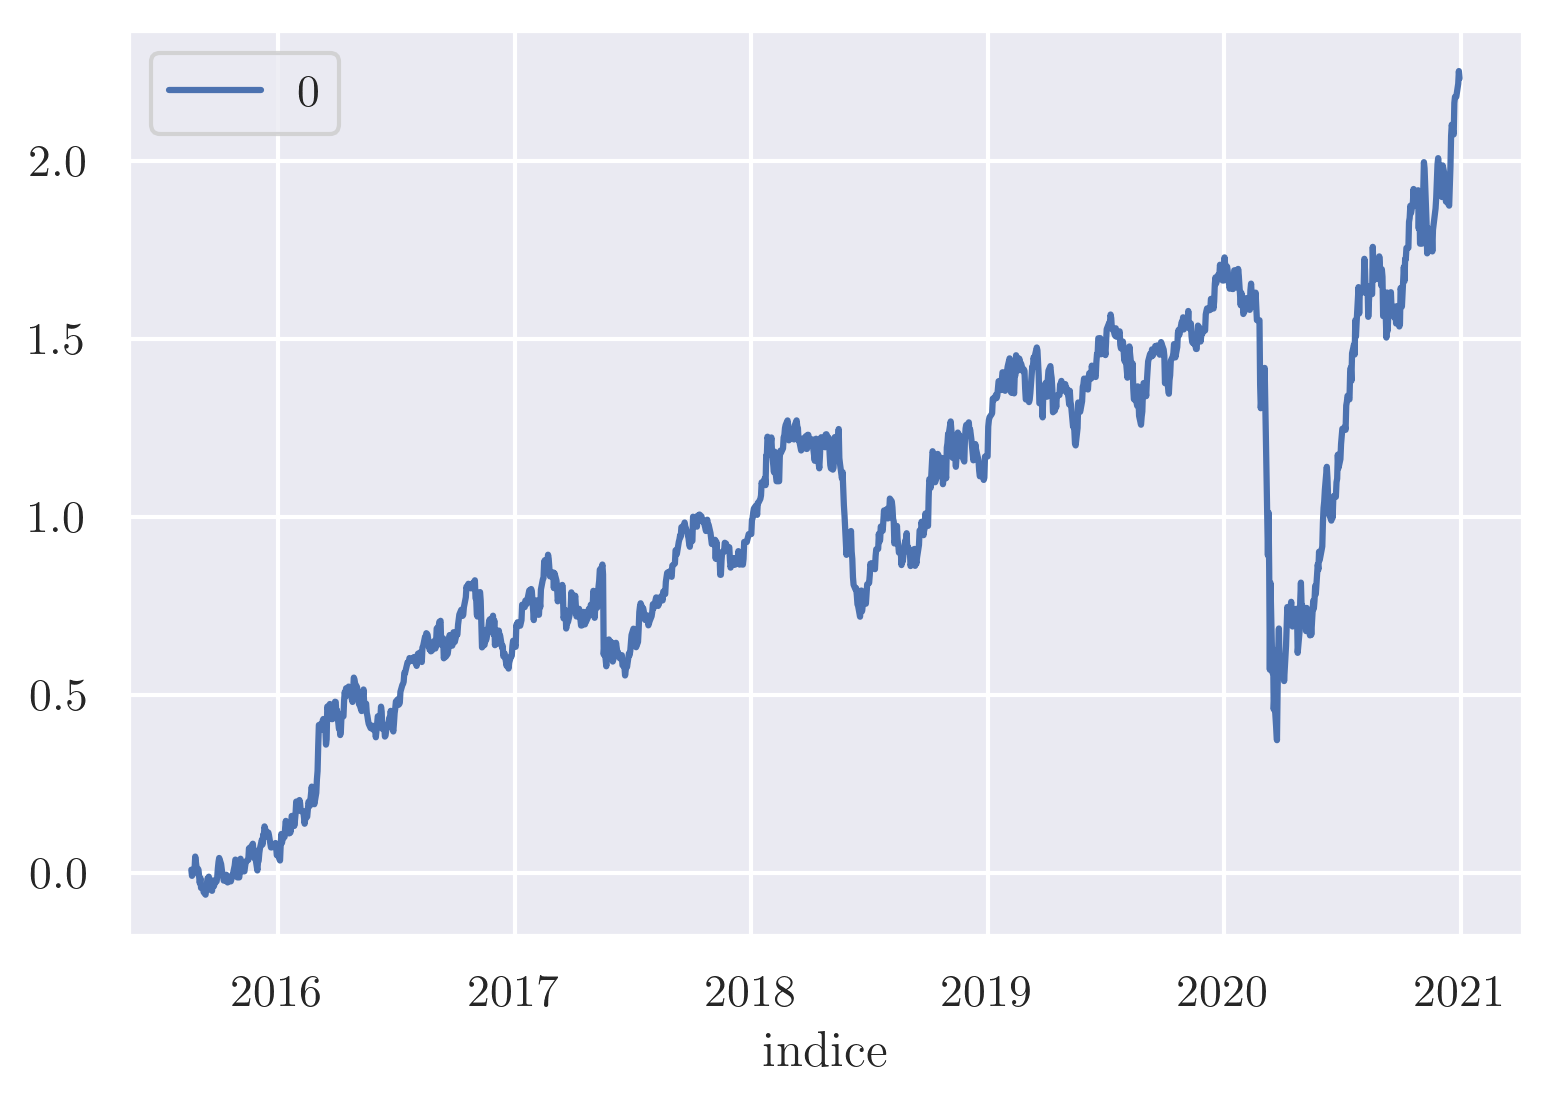

In [10]:
#----------------------------------------------------------------------------------------------
#  Guarda retorno dos portfolios otimizados
#----------------------------------------------------------------------------------------------   
    
df_ret_acao_per = pd.DataFrame()
df_ret_opt = pd.DataFrame()
itera = 0
acao = 0
t = janela_retornos
while t < T:
        
    retornos_aux = np.array(df_Retornos.iloc[(t+1):(t+janela_reb+1)])
    
    if itera > 0:
        w_novo = np.array(df_w.iloc[:,itera])
        df_ret_opt.iloc[len(df_ret_opt)-1,0] = df_ret_opt.iloc[len(df_ret_opt)-1,0] - np.abs(w_novo-w_aux).sum()*custo
    
    w_aux = np.array(df_w.iloc[:,itera])
        
    for i in range(0,retornos_aux.shape[0]):
            
        df_ret_opt = pd.concat([df_ret_opt, 
                                   pd.DataFrame(data=[(w_aux*retornos_aux[i,:]).sum()])], 
                                   axis = 0)
            
    itera = itera + 1    
    t = t + janela_reb

df_ret_opt.index = df_Retornos.index[(janela_retornos+1):len(df_Retornos.index)]

sns.lineplot(data = np.exp(df_ret_opt.cumsum())-1)

df_ret_opt.to_csv(str_dir + 'BRANDT_TESTE.csv')

#----------------------------------------------------------------------------------------------
#  Guarda resultados do ajuste dos modelos aos indicadores das ações
#----------------------------------------------------------------------------------------------   

df_accuracy.to_csv(str_dir + 'Accuracy.csv')
df_auc.to_csv(str_dir + 'AUC_Score.csv')
